In [28]:
# LIBRARY IMPORTS

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree,svm
from sklearn.metrics import accuracy_score

In [29]:
# DATASET IMPORTS AND SUMMARY

train = pd.read_csv('train.csv')
train.info()
train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


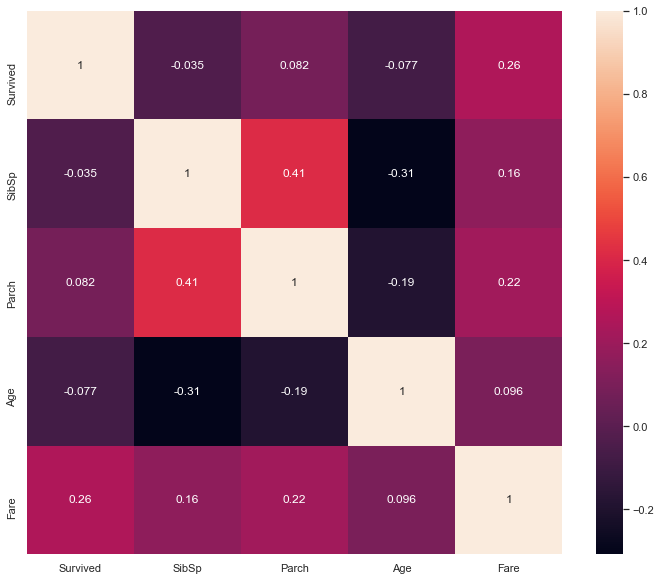

In [30]:
# CORRELATION BETWEEN SURVIVABILITY AND OTHER VARIABLES

heatmap = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Sex", "Fare"]].corr(), annot = True)
sns.set(rc={'figure.figsize':(12,10)})

In [31]:
# REMOVE UNNECESSARY COLUMNS

drop = ["PassengerId", "Name", "Ticket", "Cabin"]
train.drop(drop, axis = 1, inplace = True)
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


In [32]:
# NA TRAIN VALUES

train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [33]:
# NA VALUE CLEANUP

# Age: (Use random values between the Mean and the Standard Deviation)
mean = train["Age"].mean()
std = train["Age"].std()
rand_age = np.random.randint(mean - std, mean + std, size = 177)
age_slice = train["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
train["Age"] = age_slice

# Embarked: (Use most common value for NA)
train["Embarked"].value_counts()
train["Embarked"] = train["Embarked"].fillna('S')

train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [34]:
# CATEGORICAL VARIABLES TO NUMERICAL

genders = {"male": 0, "female": 1}
train["Sex"] = train["Sex"].map(genders)

ports = {"S": 0, "C": 1, "Q": 2}
train["Embarked"] = train["Embarked"].map(ports)

train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0
5,0,3,0,25.0,0,0,8.4583,2
6,0,1,0,54.0,0,0,51.8625,0
7,0,3,0,2.0,3,1,21.0750,0
8,1,3,1,27.0,0,2,11.1333,0
9,1,2,1,14.0,1,0,30.0708,1


In [35]:
# MACHINE LEARNING MODEL

train_x = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
train_y = train[['Survived']]
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

Accuracy = 70.94972067039106 %


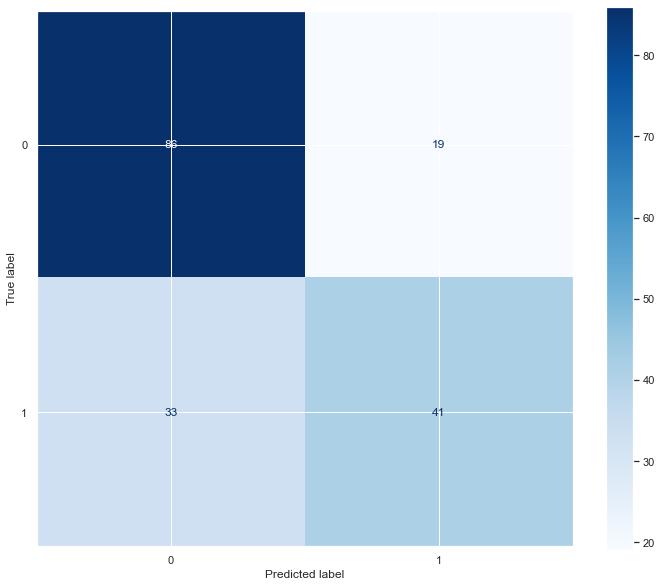

In [36]:
# K-NEIGHBOR CLASSIFIER

knc = KNeighborsClassifier(5)
knc.fit(x_train, y_train.values.ravel())
knc_y_pred = knc.predict(x_test)
knc_accuracy = accuracy_score(y_test,knc_y_pred)*100
plot_confusion_matrix(knc, x_test, y_test, cmap=plt.cm.Blues)

print("Accuracy =",knc_accuracy, "%")

Accuracy = 78.2122905027933 %


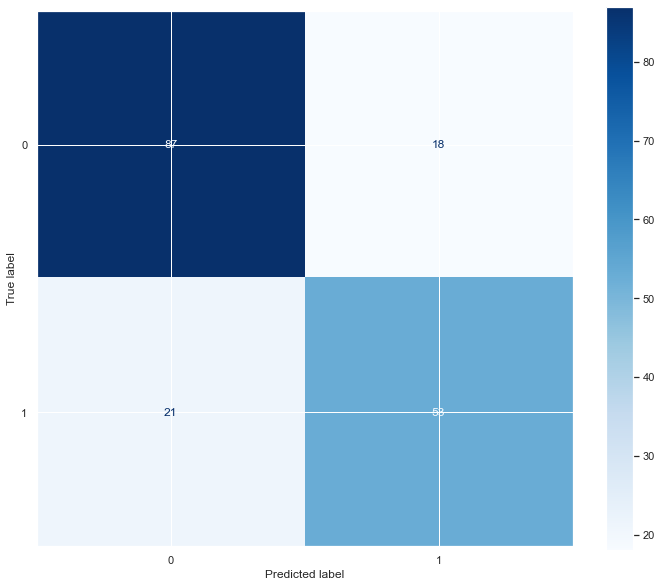

In [47]:
# LOGISTIC REGRESSION

lr = LogisticRegression(max_iter=150)
lr.fit(x_train, y_train.values.ravel())
lr_y_pred = lr.predict(x_test)
lr_accuracy = accuracy_score(y_test,lr_y_pred)*100
plot_confusion_matrix(lr,x_test,y_test, cmap=plt.cm.Blues)

print("Accuracy =",lr_accuracy, "%")

Accuracy = 82.12290502793296 %


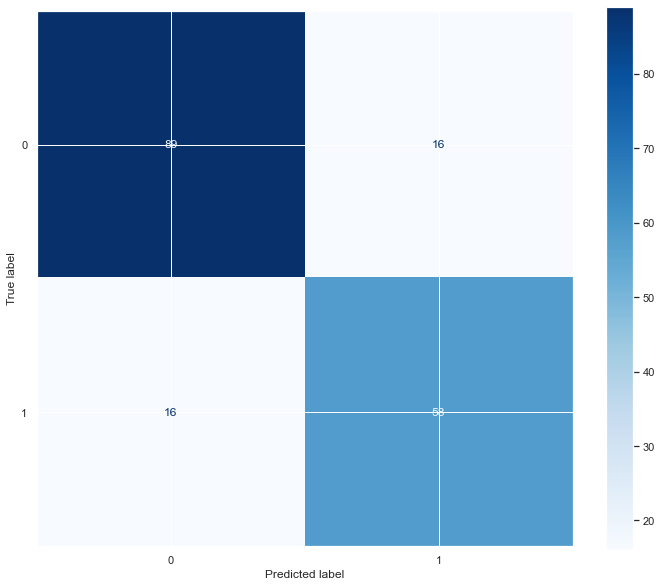

In [38]:
# RANDOM FORESTS

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train.values.ravel())
rfc_y_pred = rfc.predict(x_test)
rfc_accuracy = accuracy_score(y_test,rfc_y_pred) * 100
plot_confusion_matrix(rfc,x_test,y_test, cmap=plt.cm.Blues)

print("Accuracy =",rfc_accuracy, "%")

Accuracy = 65.36312849162012 %


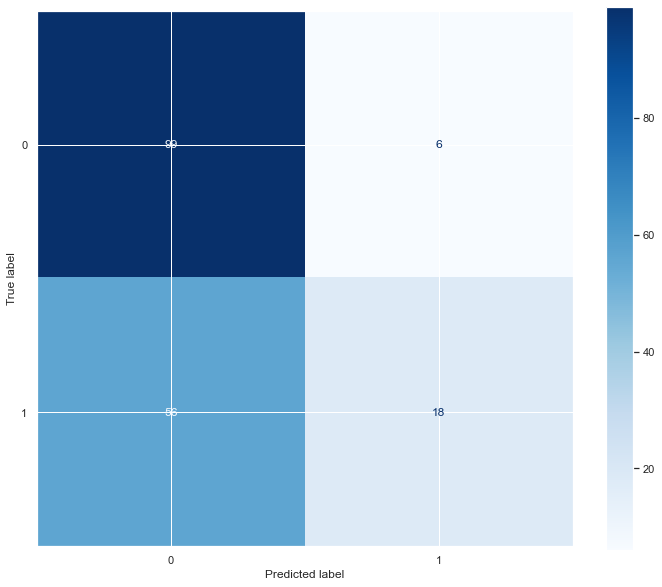

In [39]:
# SUPPORT VECTOR MACHINE

svmach = svm.SVC()
svmach.fit(x_train, y_train.values.ravel())
svm_y_pred = svmach.predict(x_test)
svm_accuracy = accuracy_score(y_test,svm_y_pred)*100
plot_confusion_matrix(svmach,x_test,y_test, cmap=plt.cm.Blues)

print("Accuracy =",svm_accuracy, "%")

Accuracy = 79.3296089385475 %


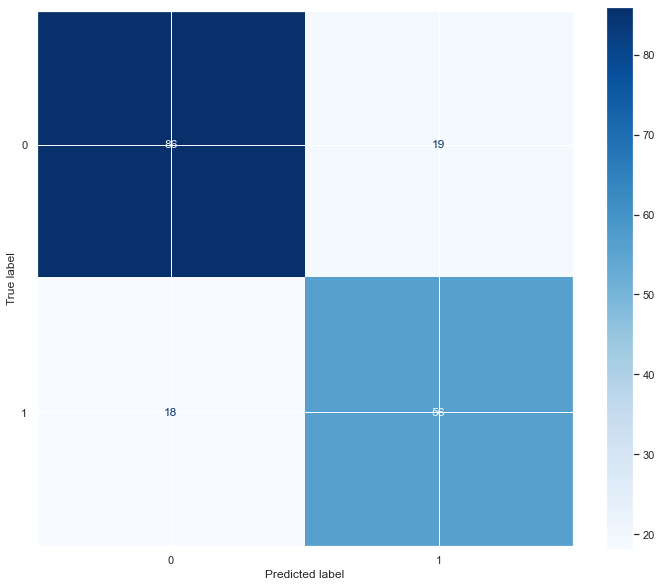

In [40]:
# DECISION TREES

dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(x_train, y_train.values.ravel())
dtc_y_pred = dtc.predict(x_test)
dtc_accuracy = accuracy_score(y_test,dtc_y_pred)*100
plot_confusion_matrix(dtc,x_test,y_test, cmap=plt.cm.Blues)

print("Accuracy =",dtc_accuracy, "%")

In [41]:
# KAGGLE SUBMISSION USING RANDOM FORESTS

test = pd.read_csv('test.csv')
test.info()
test.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [42]:
# REMOVE UNNECESSARY COLUMNS

drop = ["PassengerId", "Name", "Ticket", "Cabin"]
test.drop(drop, axis = 1, inplace = True)
test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
5,3,male,14.0,0,0,9.2250,S
6,3,female,30.0,0,0,7.6292,Q
7,2,male,26.0,1,1,29.0000,S
8,3,female,18.0,0,0,7.2292,C
9,3,male,21.0,2,0,24.1500,S


In [43]:
# NA TEST VALUES

test.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [44]:
# NA VALUE CLEANUP

# Age: (Use random values between the Mean and the Standard Deviation)
mean = test["Age"].mean()
std = test["Age"].std()
rand_age = np.random.randint(mean-std, mean+std, size = 86)
age_slice = test["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
test["Age"] = age_slice

# Fare: (Use the Mean)
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [45]:
# CATEGORICAL VARIABLES TO NUMERICAL

genders = {"male": 0, "female": 1}
test["Sex"] = test["Sex"].map(genders)

ports = {"S": 0, "C": 1, "Q": 2}
test["Embarked"] = test["Embarked"].map(ports)

test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,2
1,3,1,47.0,1,0,7.0000,0
2,2,0,62.0,0,0,9.6875,2
3,3,0,27.0,0,0,8.6625,0
4,3,1,22.0,1,1,12.2875,0
5,3,0,14.0,0,0,9.2250,0
6,3,1,30.0,0,0,7.6292,2
7,2,0,26.0,1,1,29.0000,0
8,3,1,18.0,0,0,7.2292,1
9,3,0,21.0,2,0,24.1500,0


In [46]:
# KAGGLE SUBMISSION FILE - RANDOM FORESTS

x_test_kaggle = test
y_pred_kaggle = rfc.predict(x_test_kaggle)
originaltest = pd.read_csv('test.csv')
submission = pd.DataFrame({
        "PassengerId": originaltest["PassengerId"],
        "Survived": y_pred_kaggle
    })

submission.to_csv('kaggle.csv', index = False)